<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/template%20Series%20temporales/GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo autorregresivo con heterocedasticidad condicional generalizado

$$ \sigma_{t}^{2} = \omega+\alpha_{1}\epsilon_{t-1}^{2}+\beta_{1}\sigma_{t-1}^{2} $$

## Importación de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")
sns.set()

#Prueba Logverosimilitud
# requiere que los modelos esten anidados
# p1 + q1 > p2 +q2
# p1 >= p2
# q1 >= q2
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

# carga de archivo
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/cccg8105/curso-series-temporales/master/7.%20ARMA%20autorregresivos%20de%20medias%20moviles/Python/Index2018.csv")
raw_csv_data.head(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


### Formateo de datos

In [2]:
dateColumnName = "date"
analizedValue = "ftse"
unused_columns = ['spx','dax','ftse','nikkei']

df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

# Formateo de dataset
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp[dateColumnName], dayfirst = True)
df_comp.set_index(dateColumnName, inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

df_comp['analizedValue']=df_comp[analizedValue]

df_comp = df_comp.drop(unused_columns, axis=1)
# data frame para analizar
df_comp.head(5)

,analizedValue
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


### Separación en entrenamiento y prueba

In [3]:
porcentajeEntrenamiento = 0.8
size = int(len(df_comp)*porcentajeEntrenamiento)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Serie temporal

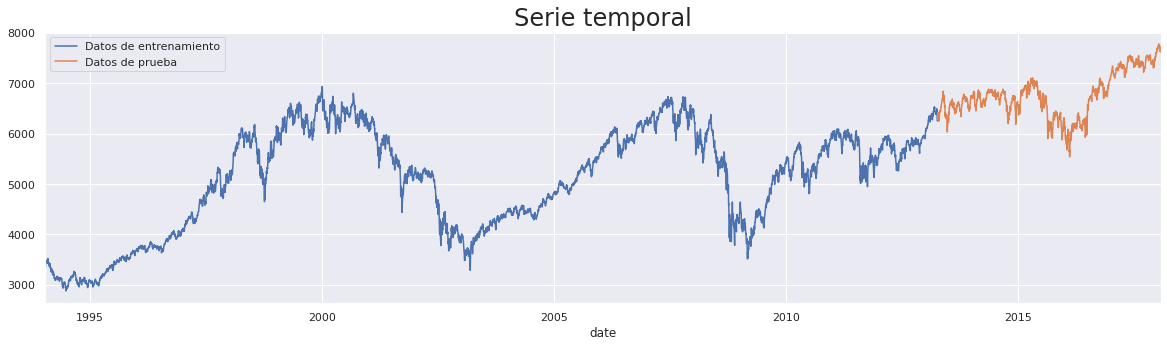

In [4]:
df.analizedValue.plot(figsize = (20,5), label = 'Datos de entrenamiento')
df_test.analizedValue.plot(figsize = (20,5), label = 'Datos de prueba')
plt.title("Serie temporal", size= 24)
plt.legend(loc='upper left')
plt.show()

## Retornos

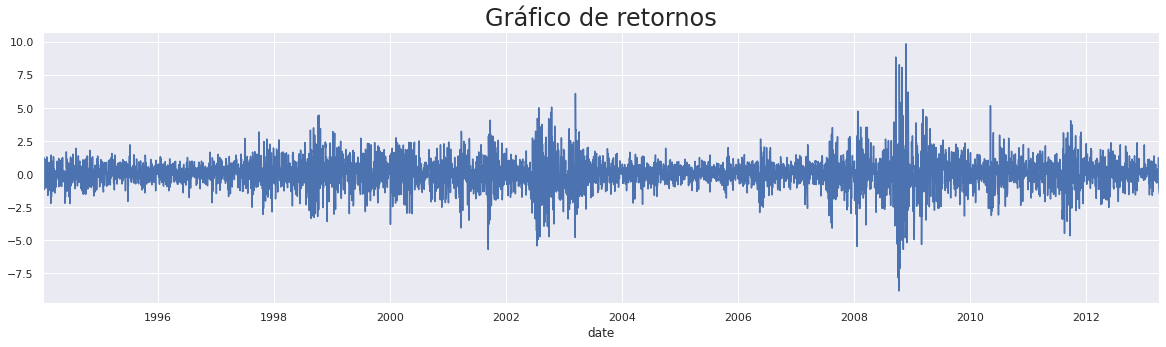

In [5]:
df['returns'] = df.analizedValue.pct_change(1)*100
df.returns.plot(figsize = (20,5), label = 'Retornos')
plt.title("Gráfico de retornos", size= 24)
plt.show()

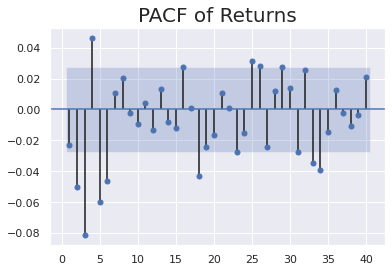

In [6]:
sgt.plot_pacf(df.returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Returns", size = 20)
plt.show()

## Volatilidad

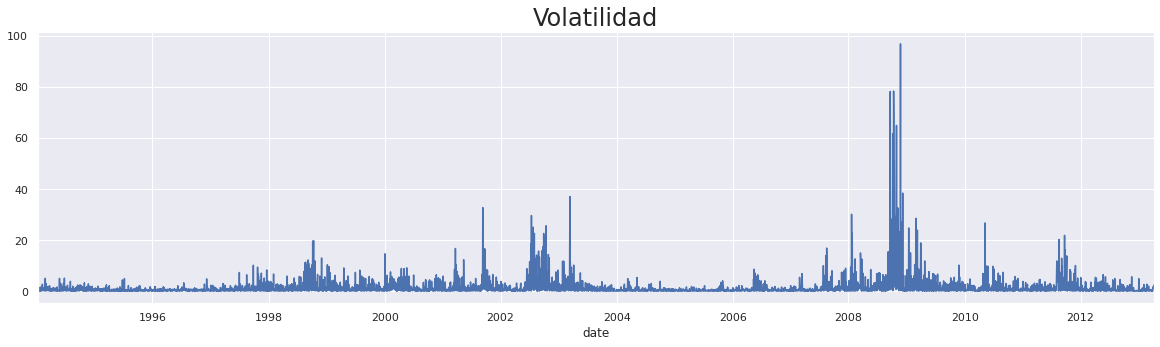

In [7]:
df['sq_returns'] = df.returns.mul(df.returns)
df.sq_returns.plot(figsize=(20,5))
plt.title("Volatilidad", size = 24)
plt.show()

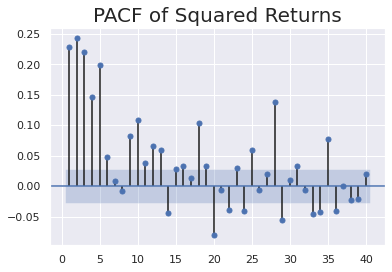

In [8]:
sgt.plot_pacf(df.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.show()

## Modelo GARCH

In [9]:
!pip install arch

     |████████████████████████████████| 798kB 5.6MB/s 


In [11]:
from arch import arch_model

model_garch_1_1 = arch_model(df.returns[1:], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_1_1 = model_garch_1_1.fit(update_freq = 5)
results_garch_1_1.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6972.734736835859
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.088042271316
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366189893
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Mon, Nov 23 2020   Df Residuals:                     5016
Time:                        23:46:37   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

Es normal que GARCH(1,1) sea el mejor modelo para predecir la volatilidad 

In [12]:
model_garch_3_1 = arch_model(df.returns[1:], mean = "Constant",  vol = "GARCH", p = 3, q = 1)
results_garch_3_1 = model_garch_3_1.fit(update_freq = 5)
results_garch_3_1.summary()

Iteration:      5,   Func. Count:     49,   Neg. LLF: 6974.886816187958
Iteration:     10,   Func. Count:     94,   Neg. LLF: 6968.53820803195
Iteration:     15,   Func. Count:    134,   Neg. LLF: 6967.731020048997
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6967.731020049635
            Iterations: 15
            Function evaluations: 134
            Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6967.73
Distribution:                  Normal   AIC:                           13947.5
Method:            Maximum Likelihood   BIC:                           13986.6
                                        No. Observations:                 5020
Date:                Mon, Nov 23 2020   Df Residuals:                     5014
Time:                        23:51:00   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.187e-02      3.924  8.721e-05 [2.330e-02,6.982e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0129  4.816e-03      2.687  7.217e-03  [3.500e-03,2.238e-02]
alpha[1]       0.0547  1.665e-02      3.285  1.019e-03  [2.207e-02,8.736e-02]
alpha[2]       0.0389  2.505e-02      1.553      0.120 [-1.018e-02,8.800e-02]
alpha[3]       0.0000  2.572e-02      0.000      1.000 [-5.041e-02,5.041e-02]
beta[1]        0.8974  2.245e-02     39.978      0.000      [  0.853,  0.941]
=============================================================================

Covariance estimator: robust
"""